# Apple Lead Data Scientist Test - Solution

This document presents a complete solution to the Apple Lead Data Scientist Test. In this solution, we:
- Load and preprocess the synthetic dataset (`apple_data.csv`)
- Conduct exploratory data analysis (EDA)
- Perform feature engineering
- Build a classification model to predict purchase likelihood
- Tune the model using GridSearchCV
- Discuss deployment considerations and business implications

> **Note:** The synthetic dataset can be generated using the provided dataset generation script. Ensure that `apple_data.csv` is in your working directory before running this solution.

---

## Table of Contents

1. [Data Loading and Preprocessing](#data-loading-and-preprocessing)
2. [Exploratory Data Analysis (EDA)](#exploratory-data-analysis-eda)
3. [Feature Engineering](#feature-engineering)
4. [Model Building](#model-building)
5. [Model Tuning and Evaluation](#model-tuning-and-evaluation)
6. [Deployment Considerations and Business Context](#deployment-considerations-and-business-context)
7. [Conclusion](#conclusion)



In [2]:
## Data Loading and Preprocessing

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load the dataset
data = pd.read_csv('./data/apple_data.csv')
print("First few rows of the dataset:")
print(data.head())

# Convert timestamp to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Create time-based features: hour of day and day of week
data['hour'] = data['timestamp'].dt.hour
data['day_of_week'] = data['timestamp'].dt.dayofweek

# Check for missing values
print("\nMissing values in each column:")
print(data.isnull().sum())

# Display data types after conversion
print("\nData types:")
print(data.dtypes)

First few rows of the dataset:
   session_id  user_id            timestamp device_type  action    price  \
0           1      103  2023-06-22 21:36:51      iPhone    view  1692.80   
1           2      436  2023-05-10 00:41:01      iPhone    view  2988.78   
2           3      349  2023-04-05 03:58:11        iPad    view  2441.30   
3           4      271  2023-04-25 13:00:04      iPhone   click  2567.64   
4           5      107  2023-08-31 21:22:51         Mac  browse  1978.38   

  product_category  purchase  
0       smartphone         0  
1       smartphone         0  
2           tablet         0  
3       smartphone         1  
4           laptop         0  

Missing values in each column:
session_id          0
user_id             0
timestamp           0
device_type         0
action              0
price               0
product_category    0
purchase            0
hour                0
day_of_week         0
dtype: int64

Data types:
session_id                   int64
user_id      

Summary statistics:
        session_id      user_id                      timestamp        price  \
count  1500.000000  1500.000000                           1500  1500.000000   
mean    750.500000   246.823333  2023-07-03 10:13:05.931999744  1595.876207   
min       1.000000     1.000000            2023-01-01 02:38:16   200.760000   
25%     375.750000   126.000000     2023-04-04 17:59:17.500000   926.405000   
50%     750.500000   245.000000            2023-06-30 04:35:28  1620.870000   
75%    1125.250000   369.250000            2023-10-05 16:39:25  2263.620000   
max    1500.000000   499.000000            2023-12-31 19:14:46  2999.580000   
std     433.157015   142.398149                            NaN   802.868756   

          purchase         hour  day_of_week  
count  1500.000000  1500.000000  1500.000000  
mean      0.154667    11.371333     3.039333  
min       0.000000     0.000000     0.000000  
25%       0.000000     5.000000     1.000000  
50%       0.000000    11.000000  

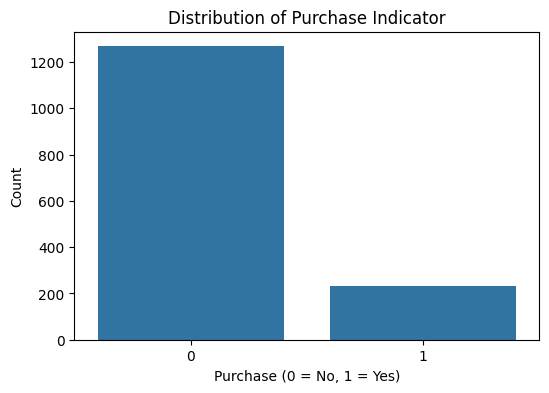

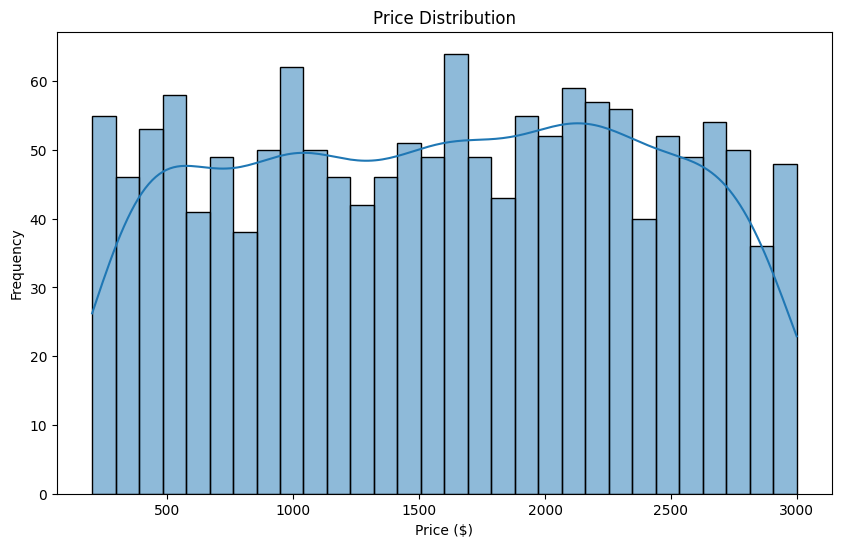

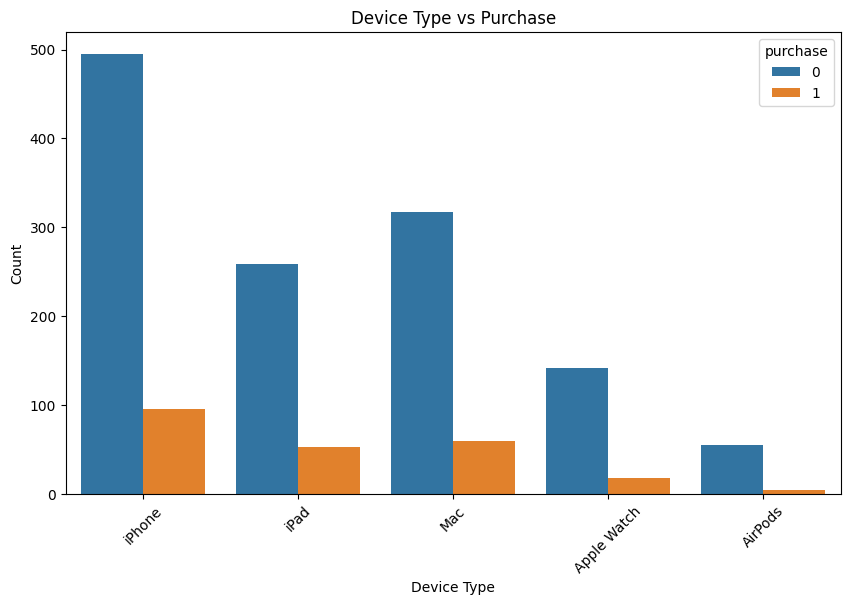

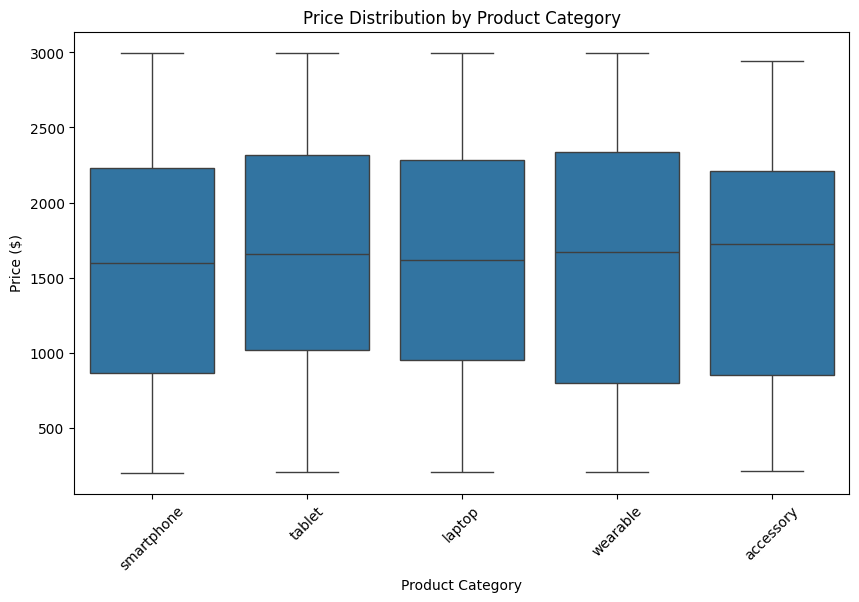

In [3]:
# Summary statistics
print("Summary statistics:")
print(data.describe())

# Count plot for purchase indicator
plt.figure(figsize=(6,4))
sns.countplot(x='purchase', data=data)
plt.title("Distribution of Purchase Indicator")
plt.xlabel("Purchase (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

# Histogram for price distribution
plt.figure(figsize=(10,6))
sns.histplot(data['price'], bins=30, kde=True)
plt.title("Price Distribution")
plt.xlabel("Price ($)")
plt.ylabel("Frequency")
plt.show()

# Count plot for device type vs. purchase
plt.figure(figsize=(10,6))
sns.countplot(x='device_type', hue='purchase', data=data)
plt.title("Device Type vs Purchase")
plt.xlabel("Device Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# Box plot for price by product category
plt.figure(figsize=(10,6))
sns.boxplot(x='product_category', y='price', data=data)
plt.title("Price Distribution by Product Category")
plt.xlabel("Product Category")
plt.ylabel("Price ($)")
plt.xticks(rotation=45)
plt.show()


In [4]:
# One-hot encode categorical variables: device_type, action, and product_category
data_encoded = pd.get_dummies(data, columns=['device_type', 'action', 'product_category'], drop_first=True)

# Verify the encoded columns
print("Columns after one-hot encoding:")
print(data_encoded.columns)


Columns after one-hot encoding:
Index(['session_id', 'user_id', 'timestamp', 'price', 'purchase', 'hour',
       'day_of_week', 'device_type_Apple Watch', 'device_type_Mac',
       'device_type_iPad', 'device_type_iPhone', 'action_browse',
       'action_click', 'action_purchase', 'action_view',
       'product_category_laptop', 'product_category_smartphone',
       'product_category_tablet', 'product_category_wearable'],
      dtype='object')


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

# Define features (X) and target (y)
# Drop columns that are identifiers or not useful for prediction
X = data_encoded.drop(columns=['purchase', 'session_id', 'user_id', 'timestamp'])
y = data_encoded['purchase']

# Split the data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Model Accuracy:", accuracy)
print("ROC AUC Score:", roc_auc)
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)


Model Accuracy: 0.9133333333333333
ROC AUC Score: 0.8853908355795148

Confusion Matrix:
[[259   6]
 [ 20  15]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       265
           1       0.71      0.43      0.54        35

    accuracy                           0.91       300
   macro avg       0.82      0.70      0.74       300
weighted avg       0.90      0.91      0.90       300



Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validated ROC AUC: 0.8688606072203087

Best Model Accuracy: 0.92
Best Model ROC AUC Score: 0.8956334231805929


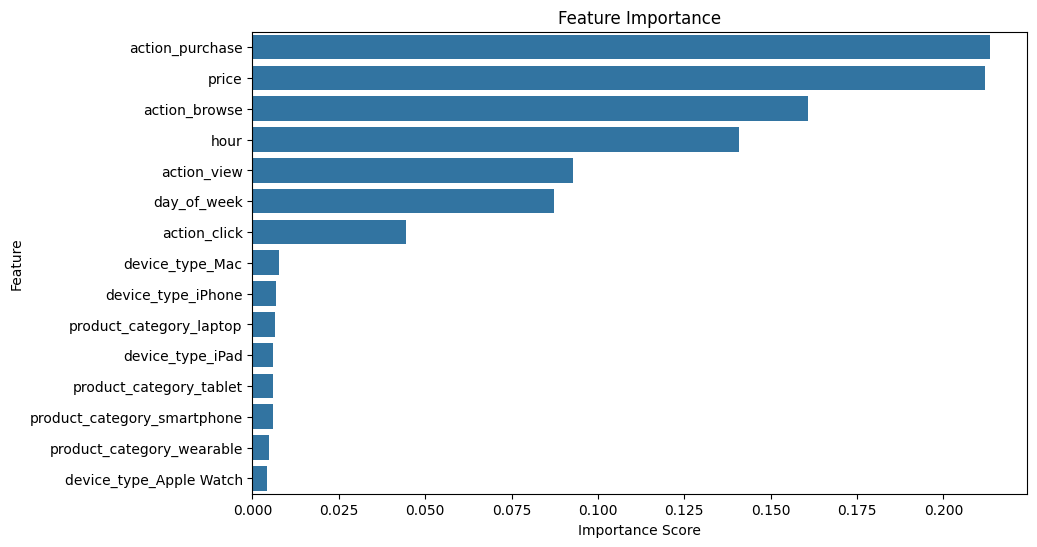

In [6]:
from sklearn.model_selection import GridSearchCV

# Define a grid of hyperparameters
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

# Set up GridSearchCV to optimize for ROC AUC score
grid_search = GridSearchCV(RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best hyperparameters and corresponding ROC AUC score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validated ROC AUC:", grid_search.best_score_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
best_accuracy = accuracy_score(y_test, y_pred_best)
best_roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

print("\nBest Model Accuracy:", best_accuracy)
print("Best Model ROC AUC Score:", best_roc_auc)

# Visualize feature importance from the best model
importances = best_model.feature_importances_
features = X.columns
feature_importance = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()
